In [2]:
import os
import gdown
import zipfile

In [13]:
main_path = Path.cwd()  # Get the current working directory

if not os.path.exists(main_path / 'datasets'):
    
    # Download the dataset (zip)

    url = 'https://drive.google.com/file/d/17fKi5QYROdVoUjmzC90TCe_Tal9hNPph/view?usp=sharing'

    output = 'dataset.zip'

    gdown.download(url, output, quiet=False, fuzzy=True)

    # Unzip the dataset

    print('Unzipping the dataset...')
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('.')

    print('Dataset unzipped successfully!')
else:
    print('Dataset already exists!')

Dataset already exists!


In [3]:
import numpy as np
import cv2
from pathlib import Path
import SimpleITK as sitk
import tensorflow as tf

def load_raw_image(image_path, segmentation_path):
    """
    Loads a raw image and its corresponding segmentation mask.

    Args:
        image_path (Path): Path to the raw image (.mhd file).
        segmentation_path (Path): Path to the segmentation mask (.mhd file).

    Returns:
        tuple: (image_np, mask_np) as NumPy arrays.
    """
    try:
        # Read the image using SimpleITK
        image_sitk = sitk.ReadImage(str(image_path))
        image_np = sitk.GetArrayFromImage(image_sitk)  # Shape: (z, y, x)

        # Read the segmentation mask using SimpleITK
        mask_sitk = sitk.ReadImage(str(segmentation_path))
        mask_np = sitk.GetArrayFromImage(mask_sitk)

        print(f"Loaded image shape: {image_np.shape}, mask shape: {mask_np.shape}")
        return image_np, mask_np
    except Exception as e:
        print(f"Error loading image or mask for {image_path.name}: {e}")
        return None, None

def extract_patches(image, mask, patch_depth=8, patch_size=(128, 128)):
    """
    Extracts patches from a 3D image and mask.

    Args:
        image (np.ndarray): 3D image array with shape (z, y, x).
        mask (np.ndarray): 3D mask array with shape (z, y, x).
        patch_depth (int): Number of slices in the depth dimension.
        patch_size (tuple): Desired (height, width) of each patch.

    Yields:
        tuple: (image_patch, mask_patch) as NumPy arrays.
    """
    z, y, x = image.shape
    patch_height, patch_width = patch_size

    # Calculate the number of patches along each dimension
    for start_z in range(0, z - patch_depth + 1, patch_depth):
        for start_y in range(0, y - patch_height + 1, patch_height):
            for start_x in range(0, x - patch_width + 1, patch_width):
                end_z = start_z + patch_depth
                end_y = start_y + patch_height
                end_x = start_x + patch_width

                image_patch = image[start_z:end_z, start_y:end_y, start_x:end_x]
                mask_patch = mask[start_z:end_z, start_y:end_y, start_x:end_x]

                yield image_patch, mask_patch

def dataset_generator(data_dir, batch_size, patch_depth=8, patch_size=(128, 128), dataset_type='train'):
    """
    A generator to load, preprocess, and output the dataset in batches.

    Args:
        data_dir (Path): Path to the dataset folder with `train` and `test` subfolders.
        batch_size (int): The number of patches per batch.
        patch_depth (int): Number of slices per patch.
        patch_size (tuple): Desired (height, width) of each patch.
        dataset_type (str): 'train' or 'test' to determine the dataset split.

    Yields:
        tuple: (images, masks) batches.
    """
    # Find all .mhd files for the dataset
    case_paths = sorted((data_dir / dataset_type).glob("Case*.mhd"))
    print(f"[Generator] Found {len(case_paths)} cases in '{dataset_type}' set.")

    while True:  # Infinite loop for generator
        # Shuffle the cases at the beginning of each epoch
        shuffled_indices = np.random.permutation(len(case_paths))
        print("[Generator] Shuffling data for new epoch.")

        image_batch = []
        mask_batch = []

        for idx in shuffled_indices:
            case_path = case_paths[idx]
            print(f"[Generator] Processing {case_path.name}...")

            # Construct segmentation path (assuming naming convention)
            segmentation_path = case_path.parent / (case_path.stem + "_segmentation.mhd")

            # Check if the segmentation file exists
            if not segmentation_path.exists():
                print(f"[Generator] Segmentation file not found for {case_path.name}. Skipping.")
                continue

            # Load the image and mask
            image, mask = load_raw_image(case_path, segmentation_path)
            if image is None or mask is None:
                print(f"[Generator] Failed to load data for {case_path.name}. Skipping.")
                continue

            # Extract patches from the image and mask
            patch_generator = extract_patches(image, mask, patch_depth=patch_depth, patch_size=patch_size)
            num_patches = 0

            for image_patch, mask_patch in patch_generator:
                # Normalize image
                image_patch = image_patch.astype(np.float32)
                image_patch = (image_patch - np.min(image_patch)) / (np.max(image_patch) - np.min(image_patch) + 1e-8)

                # Binarize mask
                mask_patch = (mask_patch > 0).astype(np.float32)

                # Add channel dimension
                image_patch = np.expand_dims(image_patch, axis=-1)  # Shape: (depth, height, width, 1)
                mask_patch = np.expand_dims(mask_patch, axis=-1)    # Shape: (depth, height, width, 1)

                image_batch.append(image_patch)
                mask_batch.append(mask_patch)
                num_patches += 1

                if len(image_batch) == batch_size:
                    print(f"[Generator] Yielding a batch of {batch_size} patches.")
                    yield np.array(image_batch), np.array(mask_batch)
                    image_batch = []
                    mask_batch = []

            print(f"[Generator] Extracted {num_patches} patches from {case_path.name}.")

        # Yield any remaining patches that didn't make a full batch
        if len(image_batch) > 0:
            print(f"[Generator] Yielding the final batch of {len(image_batch)} patches.")
            yield np.array(image_batch), np.array(mask_batch)
            image_batch = []
            mask_batch = []

def count_cases(data_dir, dataset_type):
    """
    Count the number of cases in the dataset.

    Args:
        data_dir (Path): Path to the dataset directory.
        dataset_type (str): 'train' or 'test'.

    Returns:
        int: Number of cases.
    """
    num_cases = len(list((data_dir / dataset_type).glob("Case*.mhd")))
    print(f"[Info] Number of {dataset_type} cases: {num_cases}")
    return num_cases

"""
Main function to test the dataset loading and generator.
"""
# Paths and parameters
data_dir = Path("datasets")  # Update this path as needed
train_data_dir = data_dir / "train"
test_data_dir = data_dir / "test"
batch_size = 2
patch_depth = 8
patch_size = (128, 128)
print(f"[Main] Train folder path: {train_data_dir}")
print(f"[Main] Test folder path: {test_data_dir}")
# Verify dataset directories exist
if not train_data_dir.exists():
    print(f"[Error] Training directory '{train_data_dir}' does not exist.")
    exit()
if not test_data_dir.exists():
    print(f"[Error] Testing directory '{test_data_dir}' does not exist.")
    exit()
# Generators
train_generator = dataset_generator(
    data_dir=data_dir,
    batch_size=batch_size,
    patch_depth=patch_depth,
    patch_size=patch_size,
    dataset_type="train"
)
val_generator = dataset_generator(
    data_dir=data_dir,
    batch_size=batch_size,
    patch_depth=patch_depth,
    patch_size=patch_size,
    dataset_type="test"
)
# Count cases
num_train_cases = count_cases(data_dir, 'train')
num_val_cases = count_cases(data_dir, 'test')
# Fetch a few batches from the training generator for testing
num_test_batches = 2
for batch_num in range(num_test_batches):
    print(f"\n[Main] Fetching batch {batch_num + 1} from training generator...")
    try:
        images, masks = next(train_generator)
        print(f"[Main] Batch {batch_num + 1} - Images shape: {images.shape}, Masks shape: {masks.shape}")
    except StopIteration:
        print("[Main] No more data available in the generator.")
        break
# Similarly, fetch a batch from the validation generator
print("\n[Main] Fetching a batch from validation generator...")
try:
    images, masks = next(val_generator)
    print(f"[Main] Validation Batch - Images shape: {images.shape}, Masks shape: {masks.shape}")
except StopIteration:
    print("[Main] No more data available in the validation generator.")

[Main] Train folder path: datasets\train
[Main] Test folder path: datasets\test
[Info] Number of train cases: 100
[Info] Number of test cases: 60

[Main] Fetching batch 1 from training generator...
[Generator] Found 100 cases in 'train' set.
[Generator] Shuffling data for new epoch.
[Generator] Processing Case16.mhd...
Loaded image shape: (20, 320, 320), mask shape: (20, 320, 320)
[Generator] Yielding a batch of 2 patches.
[Main] Batch 1 - Images shape: (2, 8, 128, 128, 1), Masks shape: (2, 8, 128, 128, 1)

[Main] Fetching batch 2 from training generator...
[Generator] Yielding a batch of 2 patches.
[Main] Batch 2 - Images shape: (2, 8, 128, 128, 1), Masks shape: (2, 8, 128, 128, 1)

[Main] Fetching a batch from validation generator...
[Generator] Found 60 cases in 'test' set.
[Generator] Shuffling data for new epoch.
[Generator] Processing Case22.mhd...
Loaded image shape: (24, 320, 320), mask shape: (24, 320, 320)
[Generator] Yielding a batch of 2 patches.
[Main] Validation Batch - I


[Main] Fetching batch 1 from training generator...
[Generator] Yielding a batch of 2 patches.
[Main] Batch 1 - Images shape: (2, 8, 128, 128, 1), Masks shape: (2, 8, 128, 128, 1)


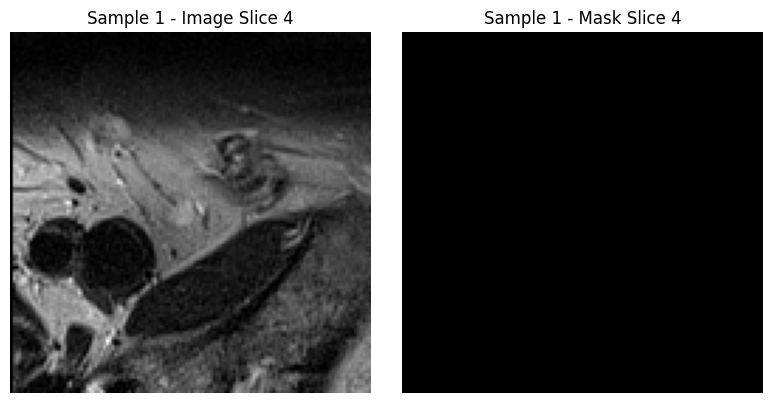

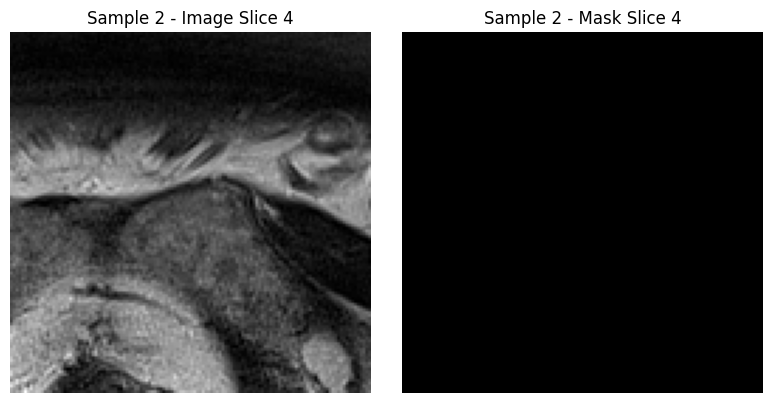


[Main] Fetching batch 2 from training generator...
[Generator] Yielding a batch of 2 patches.
[Main] Batch 2 - Images shape: (2, 8, 128, 128, 1), Masks shape: (2, 8, 128, 128, 1)


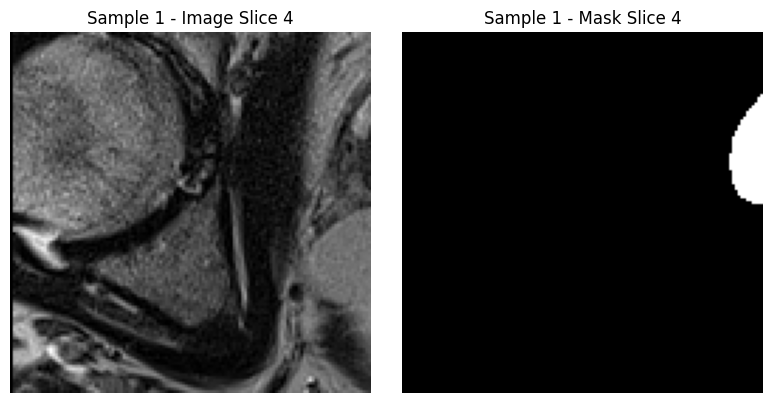

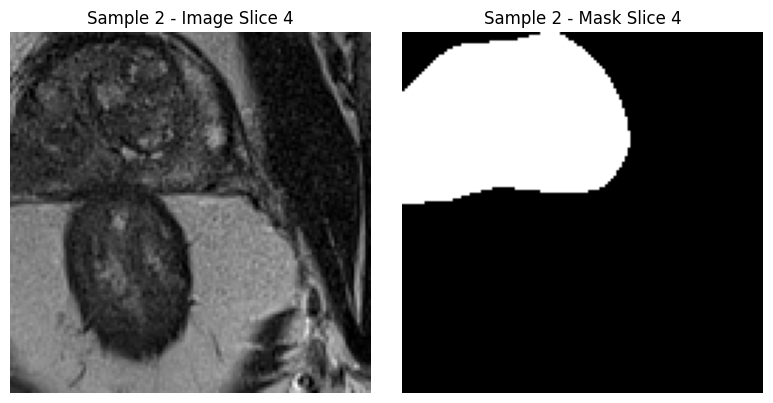


[Main] Fetching a batch from validation generator...
[Generator] Yielding a batch of 2 patches.
[Main] Validation Batch - Images shape: (2, 8, 128, 128, 1), Masks shape: (2, 8, 128, 128, 1)


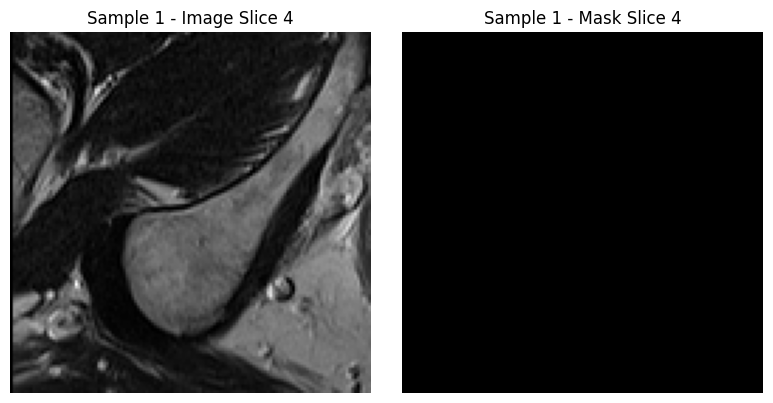

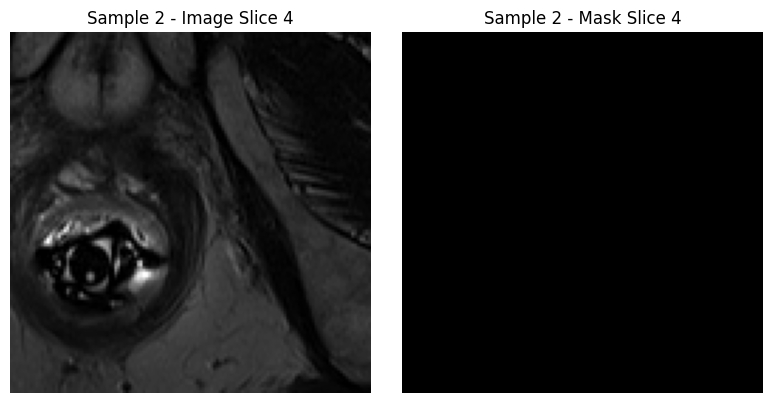

In [ ]:
import matplotlib.pyplot as plt

def visualize_batch(images, masks, num_samples=2):
    """
    Visualizes samples from a batch of images and masks.

    Args:
        images (np.ndarray): Batch of images with shape (batch_size, depth, height, width, 1).
        masks (np.ndarray): Batch of masks with shape (batch_size, depth, height, width, 1).
        num_samples (int): Number of samples to visualize from the batch.
    """
    batch_size = images.shape[0]
    num_samples = min(num_samples, batch_size)
    depth = images.shape[1]

    for i in range(num_samples):
        image = images[i, :, :, :, 0]  # Shape: (depth, height, width)
        mask = masks[i, :, :, :, 0]    # Shape: (depth, height, width)

        # Select the middle slice for visualization
        slice_idx = depth // 2

        image_slice = image[slice_idx]
        mask_slice = mask[slice_idx]

        # Create a figure with two subplots: Image and Mask
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(image_slice, cmap='gray')
        plt.title(f'Sample {i+1} - Image Slice {slice_idx}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_slice, cmap='gray')
        plt.title(f'Sample {i+1} - Mask Slice {slice_idx}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Fetch and visualize a few batches from the training generator
num_test_batches = 2
for batch_num in range(num_test_batches):
    print(f"\n[Main] Fetching batch {batch_num + 1} from training generator...")
    try:
        images, masks = next(train_generator)
        print(f"[Main] Batch {batch_num + 1} - Images shape: {images.shape}, Masks shape: {masks.shape}")
        visualize_batch(images, masks, num_samples=batch_size)
    except StopIteration:
        print("[Main] No more data available in the generator.")
        break
# Similarly, fetch and visualize a batch from the validation generator
print("\n[Main] Fetching a batch from validation generator...")
try:
    images, masks = next(val_generator)
    print(f"[Main] Validation Batch - Images shape: {images.shape}, Masks shape: {masks.shape}")
    visualize_batch(images, masks, num_samples=batch_size)
except StopIteration:
    print("[Main] No more data available in the validation generator.")

In [ ]:
# Augmentation

